In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
# import statsmodels.api as sm
from xgboost import XGBClassifier
#import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime 
from sklearn.model_selection import RandomizedSearchCV
import time
# from shapely import wkt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.display.max_rows = 1000

# 0. Input Cleaned Data

In [15]:
FPATH = "/Users/david.duong/dev/lending-club/"
FNAME= "accepted_2007_2018.csv"
DEFAULT_CATS = ['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off']
FULLY_PAID_CATS = ['Does not meet the credit policy. Status:Fully Paid','Fully Paid']


In [8]:
training_data2 = pd.read_csv('cleaned_default_data_2.csv')
training_data_recent2 = pd.read_csv('cleaned_default_data_recent.csv')

# 1. Split Data (train, test etc.) 

# 2. Fit Model

In [165]:
# Get label for full data
X = training_data2.drop('Default_flag', axis =1)
y = training_data2.Default_flag

# Split train-test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=10000)

print('Dim of X_train:', X_train.shape)
print('Dim of y_train:', y_train.shape)
print('Dim of X_test:', X_test.shape)
print('Dim of y_test:', y_test.shape)


Dim of X_train: (1011073, 116)
Dim of y_train: (1011073,)
Dim of X_test: (337025, 116)
Dim of y_test: (337025,)


In [166]:
# Get label for recent data (2014 issued loans - now)
X_recent = training_data_recent2.drop('Default_flag', axis =1)
y_recent = training_data_recent2.Default_flag

# Split train-test set
from sklearn.model_selection import train_test_split

X_train_recent, X_test_recent, y_train_recent, y_test_recent = train_test_split(X_recent, y_recent, 
                                                                                test_size=0.25, stratify = y_recent, 
                                                                                random_state=10000)

print('Dim of X_train:', X_train_recent.shape)
print('Dim of y_train:', y_train_recent.shape)
print('Dim of X_test:', X_test_recent.shape)
print('Dim of y_test:', y_test_recent.shape)


Dim of X_train: (838044, 116)
Dim of y_train: (838044,)
Dim of X_test: (279348, 116)
Dim of y_test: (279348,)


### Params

In [167]:
param = {'num_leaves':120, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']


def train_LightGBM(X_train, y_train, param, num_round):
    train_data = lgb.Dataset(X_train, label = y_train)
    
    start=datetime.now()
    lgbm=lgb.train(param,train_data,num_round)
    stop=datetime.now()
    
    process_time = stop - start
    print ("Total training time:", process_time)
    return lgbm

def LGBM_performance(preds, y_test, threshold=0.5):
    pred_label = (preds >threshold).astype(int)
    
    print ("AUC score = ", roc_auc_score(y_test, preds))
    print ("Precision = ",precision_score(y_test, pred_label) )
    print ('Recall = ', recall_score(y_test, pred_label))
    print ('F1 score = ', f1_score(y_test, pred_label))
    

    cm = confusion_matrix(y_test, pred_label)
    ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');
    plt.show()
    
def get_feature_importances(model,train_X_cols, top_n = 10):
    """
    Plot top N important features from tree models
    Also return a dataframe of features with the importance score
    """
    plt.figure(figsize=(8,12))
    #Get list of feature importance
    feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = train_X_cols,
                                   columns=['importance']).sort_values('importance', ascending=False)
    
    #Visualize top 10 feature importance
    top_vars = feature_importances[:top_n]
    sns.barplot(y = top_vars.index, x = top_vars.importance, palette="Blues_d");
    plt.title("Top {} Important Features".format(top_n), fontsize = 18);
    plt.show()
    
    return feature_importances

def XGB_performance(preds, y_test, threshold=0.5):
    pred_label = (preds[:,1] > threshold).astype(int)
    print ("AUC score = ", roc_auc_score(y_test, preds[:,1]))
    print ("Precision = ",precision_score(y_test, pred_label) )
    print ('Recall = ', recall_score(y_test, pred_label))
    print ('F1 score = ', f1_score(y_test, pred_label))
    

    cm = confusion_matrix(y_test, pred_label)
    ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');
    plt.show()

In [168]:
# Params for xgboost

xgbparams = {'objective':'binary:logistic',
                'subsample': 0.9, 
             'reg_lambda': 50.0, 
             'reg_gamma': 0.005, 
             'n_estimators': 500, 
             'min_child_weight': 0.5, 
             'max_depth': 5, 
             'learning_rate': 0.1, 
             'gamma': 0.25, 
             'colsample_bytree': 1.0, 
             'colsample_bylevel': 1.0,
                'n_jobs': -1}



## Models

### LightGBM

In [ ]:
# LightGBM for full data

num_rounds = np.arange(500, 1400, 10)

auc_scores = []

for num_round in num_rounds:
    
    lgbm1 = train_LightGBM(X_train, y_train, param, num_round)

    preds1 = lgbm1.predict(X_test)
    
    auc = roc_auc_score(y_test, preds1)
    
    auc_scores.append(auc)

max_auc_idx = np.argmax(auc_scores)
print ('{} Number of Rounds with max AUC score {}'.format(num_rounds[max_auc_idx], auc_scores[max_auc_idx]))

Total training time: 0:00:38.503076
Total training time: 0:00:38.341886
Total training time: 0:00:40.412647
Total training time: 0:00:40.752653
Total training time: 0:00:41.272532
Total training time: 0:00:43.356587
Total training time: 0:00:42.461215
Total training time: 0:00:42.571366
Total training time: 0:00:43.638897
Total training time: 0:00:43.977070
Total training time: 0:00:44.198765
Total training time: 0:00:44.070652
Total training time: 0:00:52.050238
Total training time: 0:00:59.511080
Total training time: 0:00:52.444689
Total training time: 0:00:50.339987
Total training time: 0:00:47.122981
Total training time: 0:00:48.834234
Total training time: 0:00:48.514800
Total training time: 0:00:48.672305
Total training time: 0:00:50.522262
Total training time: 0:00:50.826313
Total training time: 0:00:50.535314
Total training time: 0:00:51.498441
Total training time: 0:00:50.688126
Total training time: 0:00:52.818286
Total training time: 0:00:55.330825
Total training time: 0:00:55

1020 Number of Rounds with max AUC score 0.7342697407389549


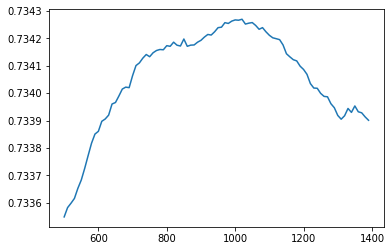

In [185]:
print ('{} Number of Rounds with max AUC score {}'.format(num_rounds[max_auc_idx], auc_scores[max_auc_idx]))
plt.plot(num_rounds, auc_scores)

In [ ]:
# Light GBM for recent data
num_rounds2 = np.arange(500, 1200, 10)

auc_scores_recent = []

for num_round in num_rounds2:
    
    lgbm1 = train_LightGBM(X_train_recent, y_train_recent, param, num_round)

    preds1 = lgbm1.predict(X_test_recent)
    
    auc = roc_auc_score(y_test_recent, preds1)
    
    auc_scores_recent.append(auc)

max_auc_idx_recent = np.argmax(auc_scores_recent)
print ('For loans issued 2014 -now: {} Number of Rounds with max AUC score {}'.format(num_rounds[max_auc_idx_recent], auc_scores_recent[max_auc_idx_recent]))


For loans issued 2014 -now: 810 Number of Rounds with max AUC score 0.7371594534778951


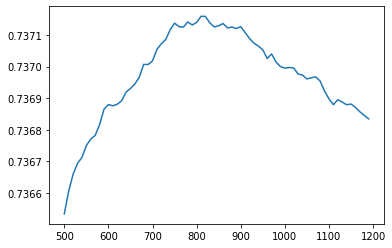

In [189]:
print ('For loans issued 2014 -now: {} Number of Rounds with max AUC score {}'.format(num_rounds[max_auc_idx_recent], auc_scores_recent[max_auc_idx_recent]))

plt.plot(num_rounds2, auc_scores_recent)

In [186]:
num_round = 1020

lgbm1 = train_LightGBM(X_train, y_train, param, num_round)

preds1 = lgbm1.predict(X_test)

Total training time: 0:01:04.138872


In [187]:
train_preds = lgbm1.predict(X_train)
roc_auc_score(y_train, train_preds)

0.796001468588246

AUC score =  0.7342697407389549
Precision =  0.33407126522441166
Recall =  0.679002079002079
F1 score =  0.44781571821026495


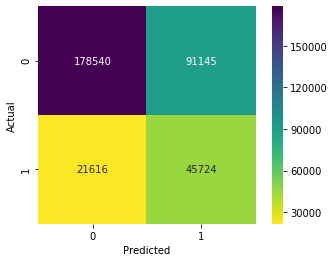

In [188]:
LGBM_performance(preds1, y_test, threshold=0.2)

### XGBoost

In [31]:
# Params search for xgboost
param_grid = {
        'n_estimators': [100, 50, 150, 200, 500],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_gamma': [0.005, 0.0001, 0.01, 0],
        'reg_lambda': [ 0.5, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]}

n_iter_search = 50

xgbsearch = XGBClassifier(n_jobs = -1)

rs_xgboost = RandomizedSearchCV(xgbsearch, param_distributions=param_grid,
                                   n_iter=n_iter_search, cv = 3, n_jobs = -1, 
                                   scoring = 'roc_auc',
                                  random_state=142)

print("Randomized search..")
search_time_start = time.time()
rs_xgboost.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Randomized search time: 12306.871062517166


In [32]:
print ("Best Index:",rs_xgboost.best_index_)
print ("Best Parameters:",rs_xgboost.best_params_)

Best Index: 11
Best Parameters: {'subsample': 0.9, 'reg_lambda': 50.0, 'reg_gamma': 0.005, 'n_estimators': 500, 'min_child_weight': 0.5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.25, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0}


#### For full data 2007 - now

In [ ]:
# XGBoost

xgboost1 = XGBClassifier(**xgbparams)

xgboost1.fit(X_train, y_train)

In [190]:
# Make predictions
probs_xgb = xgboost1.predict_proba(X_test)

In [191]:
# Get train auc score
probs_train = xgboost1.predict_proba(X_train)
roc_auc_score(y_train,probs_train[:,1])

0.7517889678702073

AUC score =  0.7342064066108785
Precision =  0.3326945412311266
Recall =  0.6806058806058806
F1 score =  0.4469234519746465


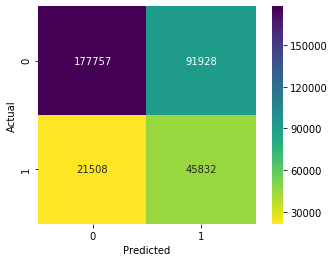

In [192]:
XGB_performance(probs_xgb, y_test, threshold=0.2)

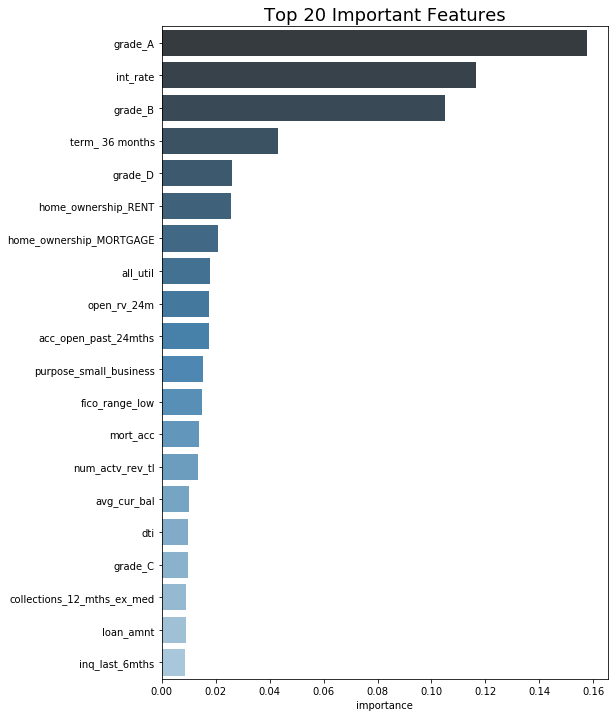

In [193]:
f_imps1 = get_feature_importances(xgboost1, X_train.columns, top_n=20)

#### For recent data: 2014 - now

In [ ]:
xgb_recent = XGBClassifier(**xgbparams)

xgb_recent.fit(X_train_recent, y_train_recent)

In [194]:
# Make predictions
probs_xgb_recent = xgb_recent.predict_proba(X_test_recent)


In [195]:
# Get train auc score
probs_train_recent = xgb_recent.predict_proba(X_train_recent)
roc_auc_score(y_train_recent,probs_train_recent[:,1])

0.7571887510719919

AUC score =  0.7369974044367316
Precision =  0.33852299330419267
Recall =  0.7091828860499014
F1 score =  0.4582864678276384


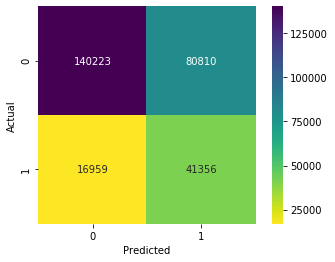

In [196]:
XGB_performance(probs_xgb_recent, y_test_recent, threshold=0.2)

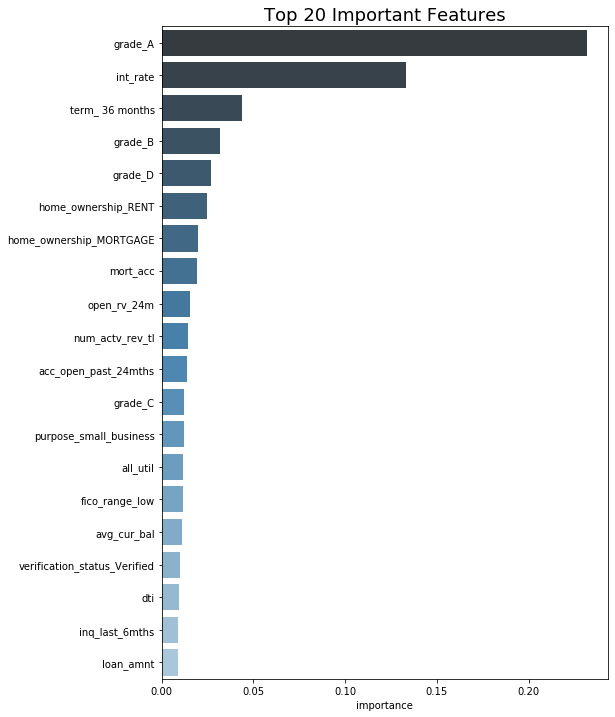

In [197]:
f_imps2 = get_feature_importances(xgb_recent, X_train_recent.columns, top_n=20)